train: PATGROUPFINAL_C
1    395
0    141
Name: count, dtype: int64
val: PATGROUPFINAL_C
1    100
0     35
Name: count, dtype: int64
Filtered test data distribution: PATGROUPFINAL_C
0    99
1    17
Name: count, dtype: int64
Epoch 1/50 - Train Loss: 0.8990, Val Loss: 0.7502, Test Loss: 0.6646
Epoch 2/50 - Train Loss: 0.8283, Val Loss: 0.7594, Test Loss: 0.6297
Epoch 3/50 - Train Loss: 0.7899, Val Loss: 0.7450, Test Loss: 0.5991
Epoch 4/50 - Train Loss: 0.7345, Val Loss: 0.7267, Test Loss: 0.5736
Epoch 5/50 - Train Loss: 0.7009, Val Loss: 0.7046, Test Loss: 0.5538
Epoch 6/50 - Train Loss: 0.6761, Val Loss: 0.6821, Test Loss: 0.5445
Epoch 7/50 - Train Loss: 0.6428, Val Loss: 0.6593, Test Loss: 0.5380
Epoch 8/50 - Train Loss: 0.6069, Val Loss: 0.6372, Test Loss: 0.5343
Epoch 9/50 - Train Loss: 0.5722, Val Loss: 0.6140, Test Loss: 0.5359
Epoch 10/50 - Train Loss: 0.5625, Val Loss: 0.5949, Test Loss: 0.5312
Epoch 11/50 - Train Loss: 0.5489, Val Loss: 0.5908, Test Loss: 0.5219
Epoch 12/50 - Tr

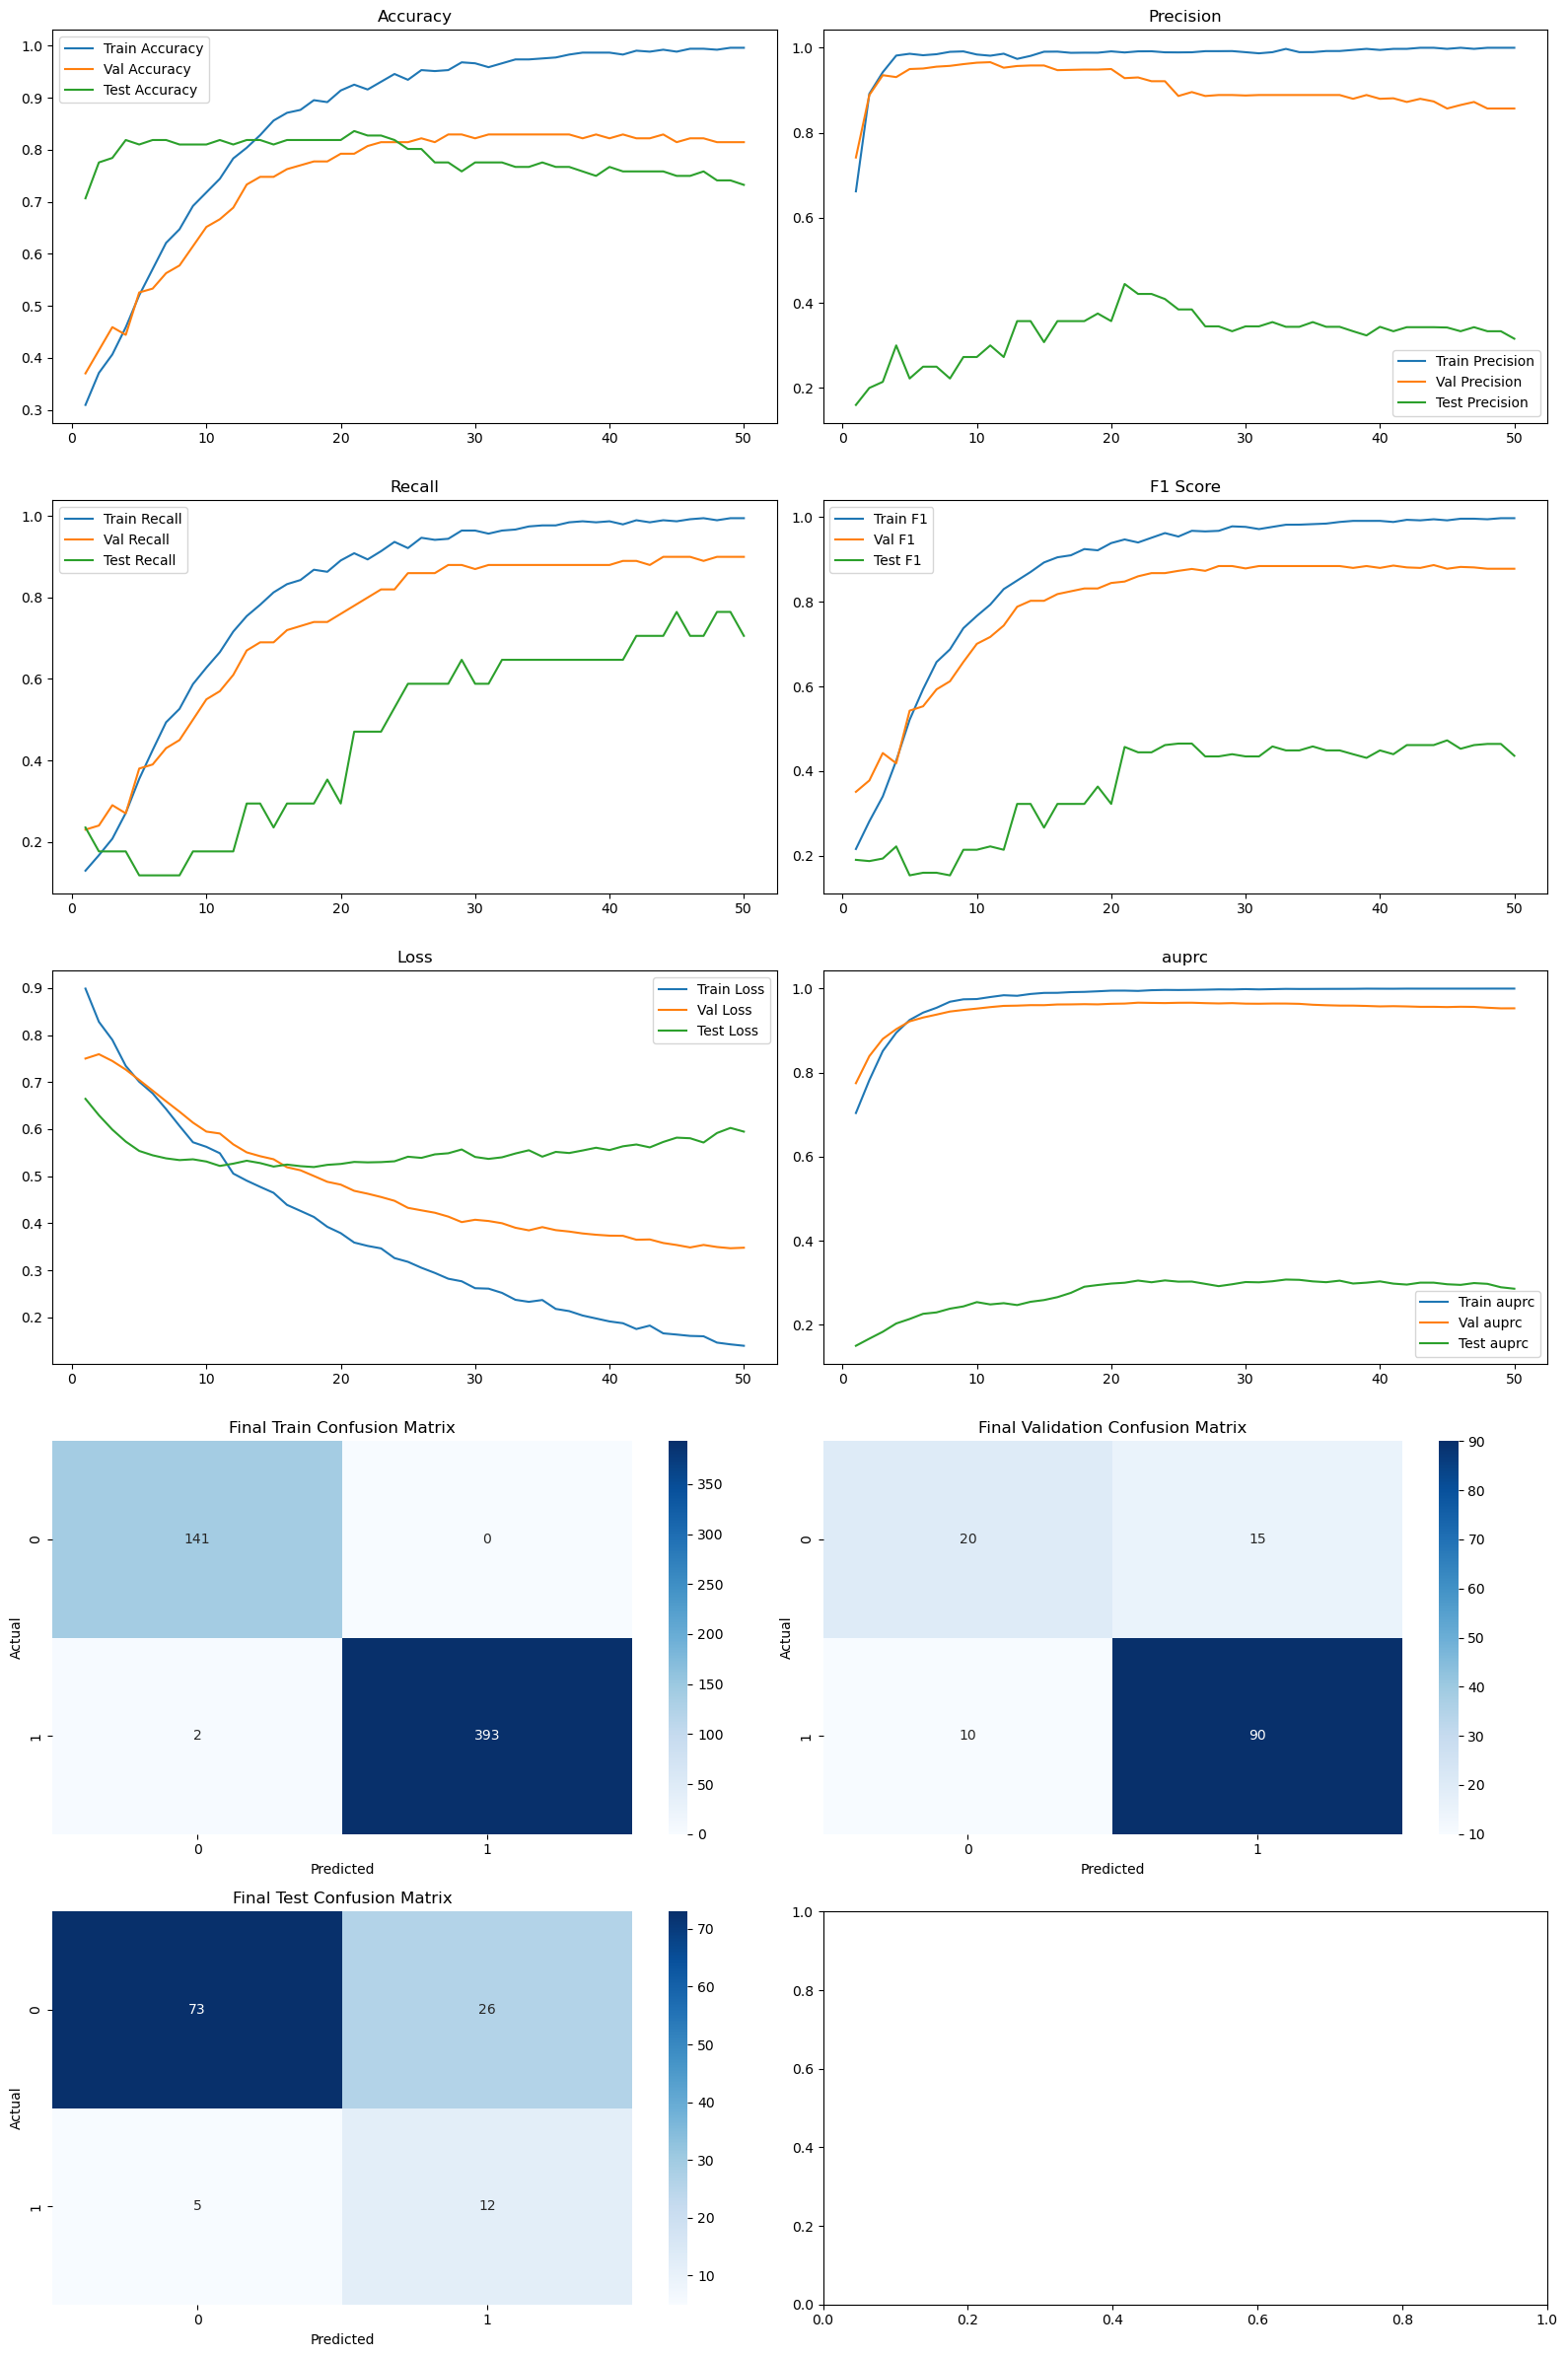

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the training datasets
train_abundance = pd.read_csv("../MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv")
train_metadata = pd.read_csv("../MetaCardis_data/train_T2D_metadata.csv")[["SampleID", "PATGROUPFINAL_C", "METFORMIN_C"]]

# Merge training datasets on SampleID
merged_data = pd.merge(train_metadata, train_abundance, on="SampleID")

# Preprocess training features and labels
features = merged_data.drop(columns=["SampleID", "PATGROUPFINAL_C", "METFORMIN_C"])
labels = merged_data["PATGROUPFINAL_C"]

# Add +1 and apply log transformation
features = np.log1p(features)

# Normalize the features using StandardScaler
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Split data into train and validation sets (stratified to preserve class distribution)
X_train, X_val, y_train, y_val = train_test_split(
    features_normalized, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"train: {y_train.value_counts()}")
print(f"val: {y_val.value_counts()}")



# Convert training and validation data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Load the test datasets
test_abundance = pd.read_csv("../MetaCardis_data/new_test_T2D_abundance_with_taxon_ids.csv")
test_metadata = pd.read_csv("../MetaCardis_data/test_T2D_metadata.csv")[["SampleID", "PATGROUPFINAL_C", "METFORMIN_C"]]

# Merge test datasets on SampleID
test_data = pd.merge(test_metadata, test_abundance, on="SampleID")

# Filter test data: Keep rows where PATGROUPFINAL_C is 1 and METFORMIN_C is 0
filtered_test_data = test_data[
    (test_data["PATGROUPFINAL_C"] == 1) & (test_data["METFORMIN_C"] == 0) | (test_data["PATGROUPFINAL_C"] == 0)
]

# Preprocess test features and labels
X_test = np.log1p(filtered_test_data.drop(columns=["SampleID", "PATGROUPFINAL_C", "METFORMIN_C"]))
y_test = filtered_test_data["PATGROUPFINAL_C"]

# Normalize and reduce dimensionality of test data (if applicable)
X_test_normalized = scaler.transform(X_test)

print(f"Filtered test data distribution: {y_test.value_counts()}")

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# # Merge test datasets on SampleID
# test_data = pd.merge(test_metadata, test_abundance, on="SampleID")

# # Preprocess test features and labels
# X_test = np.log1p(test_data.drop(columns=["SampleID", "PATGROUPFINAL_C", "METFORMIN_C"]))
# y_test = test_data["PATGROUPFINAL_C"]

# # Normalize and reduce dimensionality of test data using PCA
# X_test_normalized = scaler.transform(X_test)

# print(f"test: {y_test.value_counts()}")

# # Convert test data to PyTorch tensors
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# # Create DataLoader for test data
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the fully connected neural network
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size):
        super(FullyConnectedNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = FullyConnectedNN(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Initialize metrics storage
num_epochs = 50
train_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auprc": []}
val_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auprc": []}
test_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auprc": []}
train_losses, val_losses, test_losses = [], [], []

best_val_loss = float("inf")
patience = 5
counter = 0

# Training and evaluation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_preds, train_labels, train_probs = [], [], []
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        train_probs.extend(torch.softmax(outputs, dim=1)[:, 1].tolist())
        train_preds.extend(torch.argmax(outputs, dim=1).tolist())
        train_labels.extend(y_batch.tolist())

    train_losses.append(epoch_train_loss / len(train_loader))
    train_auprc = average_precision_score(train_labels, train_probs)
    train_metrics["auprc"].append(train_auprc)

    # Compute training metrics
    train_cm = confusion_matrix(train_labels, train_preds)
    train_acc = accuracy_score(train_labels, train_preds)
    train_prec = precision_score(train_labels, train_preds)
    train_rec = recall_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds)
    train_metrics["accuracy"].append(train_acc)
    train_metrics["precision"].append(train_prec)
    train_metrics["recall"].append(train_rec)
    train_metrics["f1"].append(train_f1)

    # Validation phase
    model.eval()
    val_preds, val_labels, val_probs = [], [], []
    epoch_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item()
            val_probs.extend(torch.softmax(outputs, dim=1)[:, 1].tolist())
            val_preds.extend(torch.argmax(outputs, dim=1).tolist())
            val_labels.extend(y_batch.tolist())
    val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if epoch_val_loss / val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

    # Compute validation metrics
    val_auprc = average_precision_score(val_labels, val_probs)
    val_metrics["auprc"].append(val_auprc)
    val_cm = confusion_matrix(val_labels, val_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds)
    val_rec = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    val_metrics["accuracy"].append(val_acc)
    val_metrics["precision"].append(val_prec)
    val_metrics["recall"].append(val_rec)
    val_metrics["f1"].append(val_f1)

    # Test phase
    test_preds, test_labels, test_probs = [], [], []
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_test_loss += loss.item()
            test_probs.extend(torch.softmax(outputs, dim=1)[:, 1].tolist())
            test_preds.extend(torch.argmax(outputs, dim=1).tolist())
            test_labels.extend(y_batch.tolist())
    test_losses.append(epoch_test_loss / len(test_loader))

    # Compute test metrics
    test_auprc = average_precision_score(test_labels, test_probs)
    test_metrics["auprc"].append(test_auprc)
    test_cm = confusion_matrix(test_labels, test_preds)
    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds)
    test_rec = recall_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)
    test_metrics["accuracy"].append(test_acc)
    test_metrics["precision"].append(test_prec)
    test_metrics["recall"].append(test_rec)
    test_metrics["f1"].append(test_f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Plot metrics and confusion matrices
fig, axs = plt.subplots(5, 2, figsize=(16, 24))

# Training, validation, and test accuracy
axs[0, 0].plot(range(1, num_epochs + 1), train_metrics["accuracy"], label="Train Accuracy")
axs[0, 0].plot(range(1, num_epochs + 1), val_metrics["accuracy"], label="Val Accuracy")
axs[0, 0].plot(range(1, num_epochs + 1), test_metrics["accuracy"], label="Test Accuracy")
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend()

# Training, validation, and test precision
axs[0, 1].plot(range(1, num_epochs + 1), train_metrics["precision"], label="Train Precision")
axs[0, 1].plot(range(1, num_epochs + 1), val_metrics["precision"], label="Val Precision")
axs[0, 1].plot(range(1, num_epochs + 1), test_metrics["precision"], label="Test Precision")
axs[0, 1].set_title("Precision")
axs[0, 1].legend()

# Training, validation, and test recall
axs[1, 0].plot(range(1, num_epochs + 1), train_metrics["recall"], label="Train Recall")
axs[1, 0].plot(range(1, num_epochs + 1), val_metrics["recall"], label="Val Recall")
axs[1, 0].plot(range(1, num_epochs + 1), test_metrics["recall"], label="Test Recall")
axs[1, 0].set_title("Recall")
axs[1, 0].legend()

# Training, validation, and test F1-score
axs[1, 1].plot(range(1, num_epochs + 1), train_metrics["f1"], label="Train F1")
axs[1, 1].plot(range(1, num_epochs + 1), val_metrics["f1"], label="Val F1")
axs[1, 1].plot(range(1, num_epochs + 1), test_metrics["f1"], label="Test F1")
axs[1, 1].set_title("F1 Score")
axs[1, 1].legend()

# Loss per epoch
axs[2, 0].plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
axs[2, 0].plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
axs[2, 0].plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
axs[2, 0].set_title("Loss")
axs[2, 0].legend()

# Training, validation, and test F1-score
axs[2, 1].plot(range(1, num_epochs + 1), train_metrics["auprc"], label="Train auprc")
axs[2, 1].plot(range(1, num_epochs + 1), val_metrics["auprc"], label="Val auprc")
axs[2, 1].plot(range(1, num_epochs + 1), test_metrics["auprc"], label="Test auprc")
axs[2, 1].set_title("auprc")
axs[2, 1].legend()

# Final epoch confusion matrices
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", ax=axs[3, 0])
axs[3, 0].set_title("Final Train Confusion Matrix")
axs[3, 0].set_xlabel("Predicted")
axs[3, 0].set_ylabel("Actual")

sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues", ax=axs[3, 1])
axs[3, 1].set_title("Final Validation Confusion Matrix")
axs[3, 1].set_xlabel("Predicted")
axs[3, 1].set_ylabel("Actual")

sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", ax=axs[4, 0])
axs[4, 0].set_title("Final Test Confusion Matrix")
axs[4, 0].set_xlabel("Predicted")
axs[4, 0].set_ylabel("Actual")

plt.tight_layout()
plt.savefig("metrics_and_confusion_matrices_with_test.png", dpi=300)
plt.show()


The problem in the above is that we want to show that since in our original data most of the patients used metformin (metformin value is one) so it cause the model to learn the features that are associated to metforminas a feature for patients. So the assumption is that if in our unseen data (test data) we give patients that has not used metformin, it should predict them as control

But still maybe the recal value be the same but we find a better features.

using oversampling to balance the data

1. Reduced Model Complexity: Simplified architecture with smaller layers.
2. Regularization: Added L2 regularization (weight_decay) and dropout layers.
3. Data Augmentation (SMOTE): Added synthetic data generation to increase diversity.
4. Learning Rate Adjustment: Reduced the learning rate to 0.0001 for more gradual training.